# Getting tensorflow-serving working on eagle

First, built a tensorflow-serving docker container in /projects/rlmolecule/pstjohn/containers with
```bash
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg docker://tensorflow/serving
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving-gpu.simg docker://tensorflow/serving:latest-gpu
```

*NOTE:* I apparently didn't build a GPU-capable image; that will probably have to happen following these instructions https://www.tensorflow.org/tfx/serving/docker#running_a_gpu_serving_image

In [1]:
# Be a good citizen when running this on a shared DAV node
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_memory_growth(gpus[0], True)
import nfp

[]


In [2]:
# Load up the data we'll be fitting, in this case Yield Sooting Index (10.1016/j.combustflame.2017.12.005)
import pandas as pd
data = pd.read_csv('ysi.csv', index_col=0)
data.head()

,Species,YSI,SMILES,CAS,Formula,Ref,Type,YSI_err
0,2-~{tert}-butylfuran,107.5,CC(C)(C)c1ccco1,NaN,NaN,NaN,NaN,5.375
1,hex-2-yne,66.9,CC#CCCC,764-35-2,NaN,NaN,NaN,3.345
2,hept-2-yne,75.2,CC#CCCCC,1119-65-9,NaN,NaN,NaN,3.760
3,oct-2-yne,81.2,CC#CCCCCC,2809-67-8,NaN,NaN,NaN,4.060
4,"2,6,10-trimethyldodecane",109.8,CCC(C)CCCC(C)CCCC(C)C,3891-98-3,NaN,NaN,NaN,5.490


In [3]:
train = data.sample(frac=.8)
valid = data[~data.index.isin(train)]

Load NFP and construct the tensorflow inputs

In [4]:
import nfp
from tensorflow.keras import layers
from layers import NodeUpdate, EdgeUpdate, GlobalSumPooling1D

preprocessor = nfp.SmilesPreprocessor()

train_inputs = [preprocessor.construct_feature_matrices(smiles, train=True) for smiles in train.SMILES]
valid_inputs = [preprocessor.construct_feature_matrices(smiles, train=False) for smiles in valid.SMILES]

def create_dataset(inputs, targets):
    """ This process is still a bit of a pain. This does the padded batch operation
    for the above inputs to handle batching and variable-sized molecules """
    return tf.data.Dataset.from_generator(
        lambda: ((x, t) for x, t in zip(inputs, targets)),
        output_types=(preprocessor.output_types, tf.float32),
        output_shapes=(preprocessor.output_shapes, []))\
        .padded_batch(batch_size=16, 
                      padded_shapes=(preprocessor.padded_shapes(), []),
                      padding_values=(preprocessor.padding_values, 0.))\
        .prefetch(tf.data.experimental.AUTOTUNE)    


train_dataset = create_dataset(train_inputs, train.YSI).shuffle(500)
valid_dataset = create_dataset(valid_inputs, valid.YSI)

Specify and train a fairly simple GNN

In [5]:
atom_class = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond_class = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

# Initialize the atom states
atom_state = layers.Embedding(preprocessor.atom_classes, 16,
                              name='atom_embedding', mask_zero=True)(atom_class)

# This serves as a bias
atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom_class)

# Initialize the bond states
bond_state = layers.Embedding(preprocessor.bond_classes, 16,
                              name='bond_embedding', mask_zero=True)(bond_class)

for _ in range(3):
    bond_state = EdgeUpdate()([atom_state, bond_state, connectivity])
    atom_state = NodeUpdate()([atom_state, bond_state, connectivity])
    
out = layers.Dense(1)(atom_state)
out = layers.Add()([out, atom_mean])
out = GlobalSumPooling1D()(out)

model = tf.keras.Model([atom_class, bond_class, connectivity], out)
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam(1E-3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
atom_embedding (Embedding)      (None, None, 16)     272         atom[0][0]                       
__________________________________________________________________________________________________
bond_embedding (Embedding)      (None, None, 16)     592         bond[0][0]                       
______________________________________________________________________________________________

In [6]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50


/home/dduplyak/miniconda3/envs/molecule/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


29/29 - 6s - loss: 2.6318 - val_loss: 1.1101
Epoch 2/50
29/29 - 1s - loss: 0.9655 - val_loss: 0.7408
Epoch 3/50
29/29 - 1s - loss: 0.5678 - val_loss: 0.3304
Epoch 4/50
29/29 - 1s - loss: 0.2582 - val_loss: 0.1963
Epoch 5/50
29/29 - 0s - loss: 0.1944 - val_loss: 0.1601
Epoch 6/50
29/29 - 1s - loss: 0.1585 - val_loss: 0.1443
Epoch 7/50
29/29 - 1s - loss: 0.1475 - val_loss: 0.1421
Epoch 8/50
29/29 - 1s - loss: 0.1398 - val_loss: 0.1313
Epoch 9/50
29/29 - 0s - loss: 0.1363 - val_loss: 0.1441
Epoch 10/50
29/29 - 1s - loss: 0.1362 - val_loss: 0.1262
Epoch 11/50
29/29 - 0s - loss: 0.1300 - val_loss: 0.1177
Epoch 12/50
29/29 - 1s - loss: 0.1274 - val_loss: 0.1289
Epoch 13/50
29/29 - 1s - loss: 0.1220 - val_loss: 0.1105
Epoch 14/50
29/29 - 1s - loss: 0.1085 - val_loss: 0.0979
Epoch 15/50
29/29 - 1s - loss: 0.1019 - val_loss: 0.0914
Epoch 16/50
29/29 - 1s - loss: 0.0956 - val_loss: 0.0773
Epoch 17/50
29/29 - 1s - loss: 0.0838 - val_loss: 0.0715
Epoch 18/50
29/29 - 1s - loss: 0.0686 - val_loss: 0

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

/home/dduplyak/miniconda3/envs/molecule/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


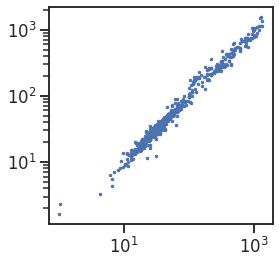

In [8]:
plt.figure(figsize=(4,4))
plt.loglog(valid.YSI, model.predict(valid_dataset), '.', ms=5)

In [9]:
# Following https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = 'ysi_model'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = ysi_model/1



INFO:tensorflow:Assets written to: ysi_model/1/assets


INFO:tensorflow:Assets written to: ysi_model/1/assets


### Running tensorflow serving

run_tf_serving.sh launches the tensorflow serving container with
```bash
SINGULARITYENV_MODEL_NAME=ysi_model singularity exec -B ./ysi_model:/models/ysi_model /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg tf_serving_entrypoint.sh
```

The log messages should include something like, among other information:
```
    Running gRPC ModelServer at 0.0.0.0:8500 ...
    Exporting HTTP/REST API at:localhost:8501 ...
```
This shows that both gRPC and HTTP endpoints are launch by default (on different ports).

In [10]:
# Here's how we prepare the data on the worker nodes and serialize it to a json

import json
from json import JSONEncoder
import numpy as np

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def trim_input(inputs, pad=True):
    """ The default SmilesPreprocessor returns some extra info we dont
    use in the simple model above, so we have to strip it down """
    data_dict = {key: val for key, val in inputs.items() 
                 if key in ['atom', 'bond', 'connectivity']}
    
    if pad:
        data_dict['atom'] = np.hstack([0, data_dict['atom']])
        data_dict['bond'] = np.hstack([0, data_dict['bond']])
        data_dict['connectivity'] = \
            np.vstack([np.array([0, 0]), data_dict['connectivity'] + 1])
        return data_dict        
 
    else:
        return data_dict

In [11]:
# Display what is in one of the training instances

train_inputs[0]

{'n_atom': 21,
 'n_bond': 20,
 'bond_indices': array([ 0,  6,  7,  0,  1,  8,  1,  2,  9, 10,  2,  3,  4,  5,  3, 11, 12,
        13,  4, 14, 15, 16,  5, 17, 18, 19,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19]),
 'atom': array([2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 'bond': array([2, 3, 3, 2, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3,
        4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 'connectivity': array([[ 0,  1],
        [ 0,  7],
        [ 0,  8],
        [ 1,  0],
        [ 1,  2],
        [ 1,  9],
        [ 2,  1],
        [ 2,  3],
        [ 2, 10],
        [ 2, 11],
        [ 3,  2],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 4,  3],
        [ 4, 12],
        [ 4, 13],
        [ 4, 14],
        [ 5,  3],
        [ 5, 15],
        [ 5, 16],
        [ 5, 17],
        [ 6,  3],
        [ 6, 18],
        [ 6, 19],
        [ 6, 20],
        [ 7,  0],
        [ 8,  0],
        [ 9,  1],
   

In [12]:
train.iloc[0]

Species    4,4-dimethyl-1-pentene
YSI                          61.4
SMILES               C=CCC(C)(C)C
CAS                      762-62-9
Formula                       NaN
Ref                             3
Type                      alkenes
YSI_err                         2
Name: 292, dtype: object

In [13]:
# We use requests to ping the TF serving model and get a response. This uses HTTP endpoint

import requests

test_input = trim_input(train_inputs[0], pad=False)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

predictions

[[58.5561256]]

In [14]:
# Do the same with padding to see if we get the same result and also time execution

import time

ts = time.time()
test_input = trim_input(train_inputs[0], pad=True)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
te = time.time()

print(predictions)
print("Time elapsed (s):", te - ts)

# Representative time here: 0.0056 s

[[58.5561256]]
Time elapsed (s): 0.005273103713989258


In [15]:
# Do the same for a number of requests, submitting them sequentially

count = 200

ts = time.time()

all_preds = []
for idx in range(count):
    test_input = trim_input(train_inputs[idx], pad=True)
    data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
    headers = {"content-type": "application/json"}
    json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
    predictions = json.loads(json_response.text)['predictions']
    all_preds.append(predictions)
    
te = time.time()

display(pd.Series(all_preds))
print("Time elapsed (s):", te - ts)

# Representative time here: 0.617 s

0      [[58.5561256]]
1      [[18.3063164]]
2      [[35.9877167]]
3      [[38.6044617]]
4      [[1481.12268]]
            ...      
195    [[28.9828758]]
196    [[128.248779]]
197    [[36.2894554]]
198    [[27.3383579]]
199     [[49.010376]]
Length: 200, dtype: object

Time elapsed (s): 0.6309821605682373


In [16]:
# Validate it's the same prediction we get from the local model
model({key: np.expand_dims(val, 0) for key, val in 
       test_input.items()})

# Printed value should match the last value in the list of predictions printed above

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[49.010376]], dtype=float32)>

### Experimenting with gRPC requests

In [17]:
import grpc
import numpy as np
import nsvision as nv
import tensorflow as tf
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

# This required:
# - pip install nsvision
# - pip install tensorflow_serving_api

In [18]:
# Following example from: https://towardsdatascience.com/image-classification-on-tensorflow-serving-with-grpc-or-rest-call-for-inference-fd3216ebd4f3

channel = grpc.insecure_channel('localhost:8500')

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
grpc_request = predict_pb2.PredictRequest()

# This needs to match: "SINGULARITYENV_MODEL_NAME=ysi_model"
grpc_request.model_spec.name = 'ysi_model'
# Not sure what this needs to match (seems arbitrary at the moment)
grpc_request.model_spec.signature_name = 'serving_default'

In [21]:
# Run a single gRPC request and time it
ts = time.time()
test_input = trim_input(train_inputs[0], pad=False)

grpc_request.inputs['atom'].CopyFrom(tf.make_tensor_proto(test_input['atom'], shape=[1, len(test_input['atom'])]))
grpc_request.inputs['bond'].CopyFrom(tf.make_tensor_proto(test_input['bond'], shape=[1, len(test_input['bond'])]))
grpc_request.inputs['connectivity'].CopyFrom(tf.make_tensor_proto(test_input['connectivity'], shape=[1]+list(np.array(test_input['connectivity']).shape)))

result = stub.Predict(grpc_request,10)
result = result.outputs['global_sum_pooling1d'].float_val[0]
print(result)

te = time.time()
print("Time elapsed (s):", te - ts)

# Representative time here: 0.0026 s (~2.1x faster than single HTTP request)

58.55612564086914
Time elapsed (s): 0.0028667449951171875


In [22]:
# Run 200 sequential gRPC requests

count = 200

all_preds = []
ts = time.time()
for idx in range(count):
    test_input = trim_input(train_inputs[idx], pad=False)
    grpc_request.inputs['atom'].CopyFrom(
        tf.make_tensor_proto(test_input['atom'], shape=[1, len(test_input['atom'])]))
    grpc_request.inputs['bond'].CopyFrom(
        tf.make_tensor_proto(test_input['bond'], shape=[1, len(test_input['bond'])]))
    grpc_request.inputs['connectivity'].CopyFrom(
        tf.make_tensor_proto(test_input['connectivity'], 
                             shape=[1]+list(np.array(test_input['connectivity']).shape)))
    result = stub.Predict(grpc_request,10)
    result = result.outputs['global_sum_pooling1d'].float_val[0]
    all_preds.append(result)
    
te = time.time()
display(pd.Series(all_preds))
print("Time elapsed (s):", te - ts)

# Printed list should match the HTTP-based predictions printed above
# Representative time here: 0.251 s

0        58.556126
1        18.306316
2        35.987717
3        38.604462
4      1481.122803
          ...     
195      28.982876
196     128.248779
197      36.289455
198      27.338358
199      49.010376
Length: 200, dtype: float64

Time elapsed (s): 0.23912644386291504


In [23]:
# Run the same 200 gRPC requests but now use non-blocking calls with Predict.future()
# Example of using Predict.future(): https://sthalles.github.io/serving_tensorflow_models/

ts = time.time()

count = 200
results = []

# Submit all requests in a non-blocking, asynchronous way
for idx in range(count):
    test_input = trim_input(train_inputs[idx], pad=False)

    grpc_request.inputs['atom'].CopyFrom(tf.make_tensor_proto(test_input['atom'], shape=[1, len(test_input['atom'])]))
    grpc_request.inputs['bond'].CopyFrom(tf.make_tensor_proto(test_input['bond'], shape=[1, len(test_input['bond'])]))
    grpc_request.inputs['connectivity'].CopyFrom(tf.make_tensor_proto(test_input['connectivity'], shape=[1]+list(np.array(test_input['connectivity']).shape)))

    result_future = stub.Predict.future(grpc_request,10)    
    results.append(result_future)
    
# Gather predictions for all requests
final_results = []
for r in results:
    # This is what actually triggers prediction 
    v = r.result()
    v = v.outputs['global_sum_pooling1d'].float_val[0]
    final_results.append(v)

te = time.time()
display(pd.Series(final_results))
print("Time elapsed (s):", te - ts)

# Printed list should match the lists of predictions obtained using other methods 
# Representative time here: 0.0770 s

0        58.556126
1        18.306316
2        35.987717
3        38.604462
4      1481.122803
          ...     
195      28.982876
196     128.248779
197      36.289455
198      27.338358
199      49.010376
Length: 200, dtype: float64

Time elapsed (s): 0.07838320732116699


*Summary of initial performance results:*
* Single HTTP request to TF Serving: 0.005 s
* Single gRPS request (same data): 0.003 s
* 200 sequential HTTP requests (pred. for first 200 train instances): 0.617 s
* 200 sequential gRPC request (same as previous): 0.289 s
* Same 200 predictions with gRPC and non-blocking prediction (Predict.future): 0.0770
* **Total of ~8x performance improvement gained as a results of switching from HTTP to non-blocking gRPC.**  
* We didn’t need to  change how the singularity container is launched (didn’t need to add —enable_batching or other flags — although, that might provide additional speed up if tuned right).
* Didn't notice any issues with running predictions for variable-length inputs using `Predict.future()`. 

Note: these numbers are for the TF Serving container running locally, on the login node. Tests where TF Serving ran on a different node showed very similar results.

Great!, So, still todo:

1) make sure this can work on a GPU (note, the singularity call changes slightly to expose the GPU binaries... I hope this works on Eagle. I've played around a bit with this, but I can't remember if it worked)

2) Correctly configure the batching behavior on the TF serving side

3) Verify that calling and waiting for the GPU result is actually faster than just evaluating on the worker CPUs :). This would require a production-scale model though